In [19]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from numba import cuda

In [20]:
@cuda.jit
def gpu_mass_search(N: np.ndarray, H: np.ndarray, R: np.ndarray):
	# Получение асболютного значения индекса потока в сетке
	x, y = cuda.grid(2)
	# Рассматриваем каждый символ подстроки
	for k in range(N.shape[1]):
		# Декремент, если символ подстроки совпал с символом входного буффера
		if N[y, k] == H[x]:
				R[y, x - k] -= 1
	cuda.syncthreads()

In [21]:
def cpu_mass_search(N: np.ndarray, H: np.ndarray, R: np.ndarray):
  for j in range(R.shape[1]):
    for i in range(R.shape[0]):
      n = N[i]
      for k in range(len(n)):
        if n[k] == H[j]:
          R[i, j - k] -= 1
  return R

In [22]:
def cpu_mass_search_with_n_k(N: np.ndarray, H: np.ndarray, n_k: dict, R: np.ndarray):
  for i in range(len(H)):
    n_k_for_H_i = n_k[H[i]]
    for n, k in n_k_for_H_i:
      R[n, i - k] -= 1
  return R

In [23]:
def get_n_k(alphabet: np.ndarray, N: np.ndarray):
  n_k = dict([(alphabet[i], []) for i in range(len(alphabet))])
  for n in range(N.shape[0]):
    for k in range(N.shape[1]):
      n_k[N[n, k]].append((n, k))
  return n_k

In [24]:
def save_result(pathfile: str, N: np.ndarray, H: np.ndarray,
                result: np.ndarray, mode='a', sheet_name=''):
  # Для одиннаковой размерности данных result дополняется нулями.
  N_i = np.full(len(H), fill_value=None)
  position = np.full(len(H), fill_value=None)
  N_i[:len(result[0])] = result[0]
  position[:len(result[1])] = result[1]

  # Приведение списка символов (подстроки) к типу str
  # для корректной записи в excel
  new_N = [str(n) for n in N]
  # Создание DataFrame
  df = pd.DataFrame({"N": new_N, "H": H, "N_i": N_i,
                     "Position": position})
  # Если sheet_name не указан, то ставится дефолтное значение длины N
  if sheet_name == '':
    sheet_name = str(len(N))

  # Если стоит mode='a', то первая запись в файл выдаст ошибку,
  # поэтому в этом случае mode меняется на 'w'.
  try:
    with pd.ExcelWriter(pathfile, mode=mode) as writer:
      df.to_excel(writer, sheet_name=sheet_name)
  except:
    with pd.ExcelWriter(pathfile, mode='w') as writer:
      df.to_excel(writer, sheet_name=sheet_name)

Сравнение подходов

In [25]:
sizes = np.arange(160, 1600, 160)     # Размерности N и H (160, 320, ..., 1440)
iterations = 10                 # Кол-во итераций для подсчёта среднего времени
N_CHARS_IN_SUBSTRING = 2        # Кол-во символов в подстроках
BLOCK_DIM = 16                  # Размерность оси квадратного блока
BLOCK_SIZE = (BLOCK_DIM, BLOCK_DIM)
# Входной алфавит символов (0, ... , 255)
alphabet = np.arange(256)

df = {"Длина N":sizes,
          "Длина H":sizes,
          "GPU":np.zeros(len(sizes), dtype=float),
          "CPU без n_k":np.zeros(len(sizes), dtype=float),
          "CPU/GPU без n_k":np.zeros(len(sizes), dtype=float),
          "CPU с n_k":np.zeros(len(sizes), dtype=float),
          "CPU/GPU с n_k":np.zeros(len(sizes), dtype=float),
          "Одиннаковые значения":np.full(len(sizes), fill_value=True)}

df = pd.DataFrame(df, index=sizes)

# Вычисления для разных размерностей N и H
for size in sizes:

  # Случайная генерация подстрок N и входного буффера H
  N = np.random.randint(len(alphabet), size=(size, N_CHARS_IN_SUBSTRING), dtype=np.uint8)
  H = np.random.randint(len(alphabet), size=size, dtype=np.uint8)

  # Получение вхождений символов алфавита в подстроки
  n_k = get_n_k(alphabet, N)

  # Заполнение рабочей матрицы NxH значениями N_CHARS_IN_SUBSTRING
  R = np.full((size, size), fill_value=N_CHARS_IN_SUBSTRING)

  # Инициализация сетки блоков
  GRID_SIZE = (len(N) // BLOCK_DIM, len(H) // BLOCK_DIM)

  # Суммы общего времени за определённое кол-во итерация для реализаций
  gpu_common_time = []
  cpu_with_n_k_common_time = []
  cpu_without_n_k_common_time = []

  # Выполнение одних и тех же вычислений для нахождения среднего времени
  # с учётом "холодного старта"
  for _ in range(iterations + 1):

    start_time = time()
    # Пересылка данных на устройство
    dev_N = cuda.to_device(N)
    dev_H = cuda.to_device(H)
    dev_R = cuda.to_device(R)

    # Запуск вычислений на GPU
    gpu_mass_search[GRID_SIZE, BLOCK_SIZE](dev_N, dev_H, dev_R)

    # Копирование рабочей матрицы с устройства на хост
    host_R = dev_R.copy_to_host()
    gpu_common_time.append(time() - start_time)

    start_time = time()
    R_without_n_k = cpu_mass_search(N, H, R.copy())
    cpu_without_n_k_common_time.append(time() - start_time)

    start_time = time()
    R_with_n_k = cpu_mass_search_with_n_k(N, H, n_k, R.copy())
    cpu_with_n_k_common_time.append(time() - start_time)

  # Запись подсчётов времени и соответствия рабочих матриц
  df.loc[size, "GPU"] = np.mean(gpu_common_time[1:])
  df.loc[size, "CPU без n_k"] = np.mean(cpu_without_n_k_common_time[1:])
  df.loc[size, "CPU с n_k"] = np.mean(cpu_with_n_k_common_time[1:])
  df.loc[size, "Одиннаковые значения"] = np.array_equal(host_R, R_without_n_k) # and np.array_equal(R_with_n_k, R_without_n_k)

  # Получение списка найденных подстрок
  result = np.array(np.where(host_R == 0))

  # Сохранение результатов в файл xlsx с несколькими листами
  save_result("found_substrings.xlsx", N, H, result, sheet_name=f'Размер {size}')
  print(f"Результаты поиска при длине H равном {size} успешно сохранены")

# Запись значений ускорения GPU над CPU
df["CPU/GPU без n_k"] = df["CPU без n_k"] / df["GPU"]
df["CPU/GPU с n_k"] = df["CPU с n_k"] / df["GPU"]
# Вывод результатов на экран
df

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Результаты поиска при длине H равном 160 успешно сохранены
Результаты поиска при длине H равном 320 успешно сохранены
Результаты поиска при длине H равном 480 успешно сохранены
Результаты поиска при длине H равном 640 успешно сохранены
Результаты поиска при длине H равном 800 успешно сохранены
Результаты поиска при длине H равном 960 успешно сохранены
Результаты поиска при длине H равном 1120 успешно сохранены
Результаты поиска при длине H равном 1280 успешно сохранены
Результаты поиска при длине H равном 1440 успешно сохранены


,Длина N,Длина H,GPU,CPU без n_k,CPU/GPU без n_k,CPU с n_k,CPU/GPU с n_k,Одиннаковые значения
160,160,160,0.001922,0.038509,20.040871,0.000253,0.131844,True
320,320,320,0.001696,0.078369,46.213688,0.000509,0.300013,True
480,480,480,0.002392,0.179620,75.094763,0.001277,0.533751,True
640,640,640,0.003369,0.314061,93.223472,0.002161,0.641392,True
800,800,800,0.004364,0.607296,139.156979,0.003647,0.835744,False
960,960,960,0.005011,0.706907,141.070017,0.004670,0.932034,True
1120,1120,1120,0.006556,1.009324,153.942811,0.006307,0.962007,True
1280,1280,1280,0.008043,1.402273,174.353152,0.008352,1.038433,True
1440,1440,1440,0.009868,1.688825,171.141082,0.010621,1.076295,False


<Axes: title={'center': 'Сравнение времени вычислений'}, xlabel='Длина N', ylabel='Время, с'>

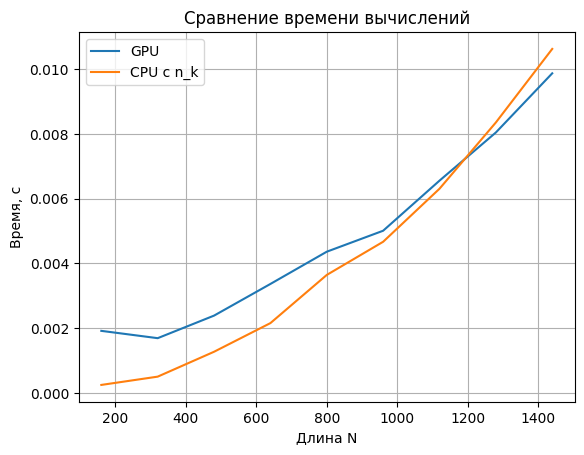

In [26]:
df.plot(x="Длина N", y=["GPU", "CPU с n_k"],
        legend=True, grid=True,
        title="Сравнение времени вычислений",
        xlabel="Длина N", ylabel="Время, с")

array([<Axes: xlabel='Длина N', ylabel='CPU/GPU'>], dtype=object)

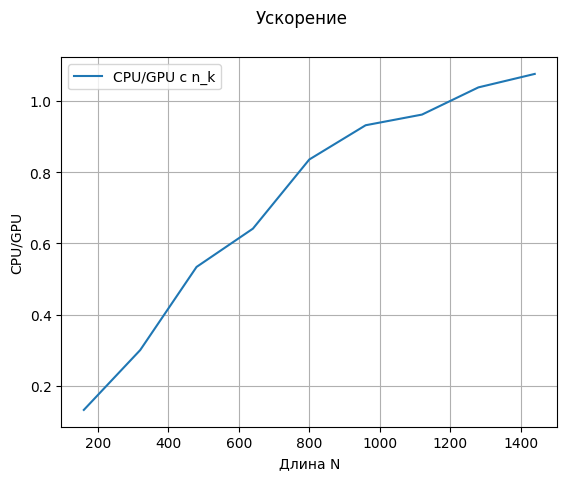

In [28]:
df.plot(x="Длина N", y="CPU/GPU с n_k",
        legend=True, grid=True, subplots=True,
        title="Ускорение",
        xlabel="Длина N", ylabel="CPU/GPU")